<li>Read water quality points and class from shapefile 
<li>list all satellite images 
<li>read satellite bands for points 
<li>create spectral or temporal dataset 
<li>train model
<li>test model 
<li>predict future

<h1>install </h1>

In [ ]:
 
 
pip install tensorflow --no-cache-dir

In [6]:
pip install tensorflow

  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl (331.9 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\Projects\\Lakes_wq\\WaterQuality_Vransko_jezero\\WaterQuality_Vransko_jezero\\.venv\\Lib\\site-packages\\tensorflow\\include\\external\\envoy_api\\envoy\\extensions\\load_balancing_policies\\client_side_weighted_round_robin\\v3\\client_side_weighted_round_robin.upb_minitable.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



In [ ]:
pip install numpy pandas geopandas  rasterio tensorflow

  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl (331.9 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\Projects\\Lakes_wq\\WaterQuality_Vransko_jezero\\WaterQuality_Vransko_jezero\\.venv\\Lib\\site-packages\\tensorflow\\include\\external\\envoy_api\\envoy\\extensions\\load_balancing_policies\\client_side_weighted_round_robin\\v3\\client_side_weighted_round_robin.upb_minitable.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



In [1]:
#Uncomment the satellite to run
satellite="Landsat" 
#satellite='Sentinel_2'
#satellite='Planet_Scope'

In [2]:
#mport xarray as xr
import numpy as np
import pandas as pd
import os
import geopandas as gpd
#initialize variables 
DATA_DIR='DATA/vrana/Landsat_new'
file_timeseries='temp_tsdf_landsat.csv'
future_path='DATA/vrana/Future/Landsat_SR'
band_names = ["B01","B02","B03","B04","B05","B06","B07", "B10"]


#define correct variables for each satellite 
if satellite== 'Landsat':
    DATA_DIR='DATA/vrana/Landsat_new'
    file_timeseries='temp_tsdf_landsat.csv'
    future_path='DATA/vrana/Future/Landsat_SR'
    band_names = ["B01","B02","B03","B04","B05","B06","B07", "B10"]
if satellite=='Sentinel_2':
    DATA_DIR='DATA/vrana/Sentinel_new'
    band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']
    file_timeseries='temp_tsdf_sentinel.csv'
    future_path = 'DATA/vrana/Future/Sentinel/'
if satellite=='Planet_Scope':
    DATA_DIR='DATA/vrana/transfer.pcloud.PnXOdLhM'
    band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8' ]
    file_timeseries='temp_tsdf_planetscope.csv'
    future_path = 'DATA/vrana/Future/Planet/'

 
print(satellite)


Landsat


In [3]:
WQ_points = gpd.read_file('DATA/vrana/AHP_WQI_0411_points_300x300.shp')
WQ_points


,pointid,WQI,Class,geometry
0,1,0.599432,7,POINT (421285.063 4866886.069)
1,2,0.611691,7,POINT (421585.063 4866886.069)
2,3,0.595140,7,POINT (420985.063 4866586.069)
3,4,0.602983,7,POINT (421285.063 4866586.069)
4,5,0.612361,7,POINT (421585.063 4866586.069)
...,...,...,...,...
313,314,0.688339,4,POINT (429385.063 4857586.069)
314,315,0.684427,4,POINT (429685.063 4857586.069)
315,316,0.683703,4,POINT (429685.063 4857286.069)
316,317,0.685591,4,POINT (429985.063 4857286.069)


In [4]:
import os
import re
from datetime import datetime
import pandas as pd
import geopandas as gpd
import rasterio

base_path = DATA_DIR
if os.path.exists(file_timeseries):
    print("File exists!")
    tsdf=pd.read_csv(file_timeseries)
else:
    print("File does not exist.") 
# --- Step 1: Extract folder dates and map to folder paths ---
    folder_date_map = {}
    for f in os.listdir(base_path):
        full_path = os.path.join(base_path, f)
        if os.path.isdir(full_path):
            match = re.search(r"(\d{8})", f)
            if match:
                date_obj = datetime.strptime(match.group(1), "%Y%m%d")
                folder_date_map[date_obj] = full_path

    folder_dates = sorted(folder_date_map.keys())
    print(folder_dates)
     # --- Step 2: Example gdf with geometry + date column ---
 
    gdf=WQ_points.copy()
    # --- Helper to find nearest available folder date ---
    def find_nearest_date(target_date, date_list):
        return min(date_list, key=lambda d: abs(d - target_date))

    # --- Step 3: Extract pixel values into separate band columns ---

    final1=[]
    for d in folder_date_map.keys():
        folder_path=folder_date_map[d]
        tiff_files = sorted([f for f in os.listdir(folder_path) if (f.lower().endswith('.tiff') or f.lower().endswith('.tif'))])
        
        for tiff_file in tiff_files:
            # Extract band code from filename (e.g., 'B04')
            #print(tiff_file)
            if satellite=="Planet_Scope":
                match_band = re.search(r'B(\d{1,2}[A]?)', tiff_file)
            else:
                match_band = re.search(r'_B(\d+[A]?)_', tiff_file)
            #print(match_band)
            if match_band:
                band_code = "B" + match_band.group(1)

                if band_code in band_names:
                    #print(d,band_code)
                    with rasterio.open(os.path.join(folder_path, tiff_file)) as src:
                        # Ensure CRS matches
                        
                            
                        for idx, row  in gdf.iterrows():
                            
                            point = gdf.to_crs(src.crs).iloc[idx].geometry
                            if gdf.crs != src.crs:
                                point = gdf.to_crs(src.crs).iloc[idx].geometry
                            #print(list(src.sample([(point.x, point.y)])))
                            val = list(src.sample([(point.x, point.y)]))[0][0]
                            final1.append({'ponit':point,'pontid':idx,'date':d,'band':band_code,'val':val,'WQI':row['WQI'],	'Class': row.Class})

                            
    print(final1)                
    tsdf=pd.DataFrame(final1)
    tsdf.to_csv(file_timeseries)
tsdf
    

File exists!


,Unnamed: 0,ponit,pontid,date,band,val,WQI,Class
0,0,POINT (541695.6890581218 4865089.811421017),0,2023-07-17,B01,0.012217,0.599432,7
1,1,POINT (541995.5332650562 4865095.259092693),1,2023-07-17,B01,0.010457,0.611691,7
2,2,POINT (541401.2926462779 4864784.519945171),2,2023-07-17,B01,0.000338,0.595140,7
3,3,POINT (541701.1365933697 4864789.967343993),3,2023-07-17,B01,0.000585,0.602983,7
4,4,POINT (542000.9808068151 4864795.41474932),4,2023-07-17,B01,0.000420,0.612361,7
...,...,...,...,...,...,...,...,...
30523,30523,POINT (549960.3313984694 4855941.508381019),313,2024-06-17,B10,300.855800,0.688339,4
30524,30524,POINT (550260.1830087263 4855946.94797058),314,2024-06-17,B10,301.494960,0.684427,4
30525,30525,POINT (550265.6224683498 4855647.096223532),315,2024-06-17,B10,302.551120,0.683703,4
30526,30526,POINT (550565.474352181 4855652.53555322),316,2024-06-17,B10,300.900240,0.685591,4


In [5]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Make sure date is datetime
tsdf['date'] = pd.to_datetime(tsdf['date'])

# Pivot: one row per (pontid, date), columns are bands
df_wide = tsdf.pivot_table(
    index=['pontid',  'date', 'WQI', 'Class'],
    columns='band',
    values='val'
).reset_index()

# Sort only by pontid  and date
df_wide = df_wide.sort_values(['pontid', 'date'])

X_list = []
ids_list = []
dates_list = []
class_list={}
Wqi={}
band_order = band_names#["B01","B02","B03","B04","B05","B07","B06", "B10"]
for pid, group in df_wide.groupby('pontid'):
    group = group.sort_values('date')
    ts_array = group[band_order].to_numpy(dtype=np.float32)  # shape: (num_times, num_bands)
    X_list.append(ts_array)
    ids_list.append(pid)
    dates_list.append(group['date'].to_numpy())
    class_list[pid]=int(group['Class'].max())
  
    Wqi[pid]=group['WQI'].max()
max_len = max(ts.shape[0] for ts in X_list)
num_bands = len(band_names)

# Pad sequences on time axis
X_padded = pad_sequences(
    X_list,
    maxlen=max_len,
    dtype='float32',
    padding='post',
    value=0.0
)  # shape: (num_points, max_len, num_bands)
X_spectral = np.transpose(X_padded, (0, 2, 1))
spec="spectral"
# shape: (num_points, num_bands, max_len)
y=list(class_list.values())

X_spectral.shape



ModuleNotFoundError: No module named 'tensorflow.python'

<h1> Define Functions </h1>

Definition of model, function for plotting model training history and confusion matrices 

In [115]:

# --- Build CNN ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization, Input
def train_model(X_train,X_test,y_train,y_test):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),  # (bands, time)

        Conv1D(16, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),

        GlobalAveragePooling1D(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # --- Train ---
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=500,
        batch_size=16,
        verbose=1
    )

    # --- Evaluate ---
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {acc:.4f}")
    return model, history
    
def plot_history(history):
    import matplotlib.pyplot as plt

    # Accuracy
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
import numpy as np
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def plot_confusion_matrix(model, X_train,X_test,y_train,y_test):
    import numpy as np

# Predict class probabilities
    y_pred_probs = model.predict(X_train)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_train,axis=1 )
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Optionally get class labels from encoder
    class_names = le.classes_

    # Plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix Train data CNN "+spec +" for " + satellite)
    plt.show()


    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=6)
    print('AUC:',metrics.auc(fpr, tpr))
    print('Accuracy: ',metrics.accuracy_score(y_true, y_pred))
    print('R2',r2_score(y_true,y_pred))
    y_pred_probs = model.predict(X_test)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test,axis=1 )
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Optionally get class labels from encoder
    class_names = le.classes_

    # Plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix Test data CNN "+spec +" for " + satellite)

    
    plt.show()
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=6)
    print('AUC:',metrics.auc(fpr, tpr))
    print('Accuracy: ',metrics.accuracy_score(y_true, y_pred))
    print('R2',r2_score(y_true,y_pred))


<h1>Spectral CNN model </h1>
Spectral CNN model extracts features of each spectral signatuere and use timeseries of spectral features for predicting WQI

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1457 - loss: 1.9756 - val_accuracy: 0.2031 - val_loss: 1.9410
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2913 - loss: 1.8926 - val_accuracy: 0.1875 - val_loss: 1.9356
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3504 - loss: 1.7753 - val_accuracy: 0.1719 - val_loss: 1.9288
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3307 - loss: 1.7113 - val_accuracy: 0.2031 - val_loss: 1.9212
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3189 - loss: 1.6160 - val_accuracy: 0.2031 - val_loss: 1.9175
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3858 - loss: 1.5285 - val_accuracy: 0.2031 - val_loss: 1.9111
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3504 - loss: 1.4998 - val_accuracy: 0.2031 - val_loss: 1.9096
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4331 - loss: 1.4030 - val_accuracy: 0.2

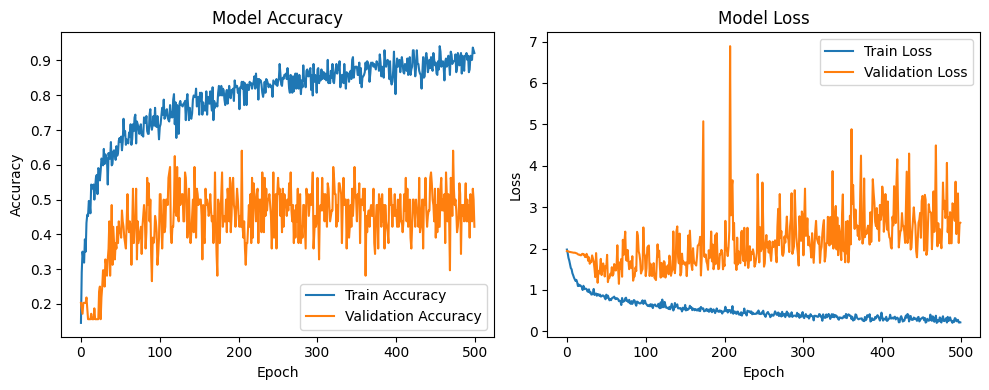

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


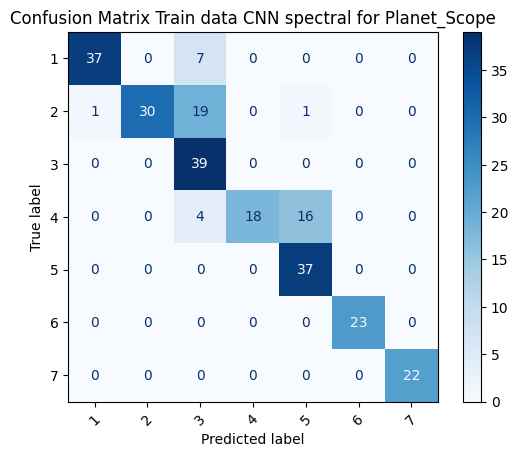

AUC: 1.0
Accuracy:  0.8110236220472441
R2 0.9149607805624641
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


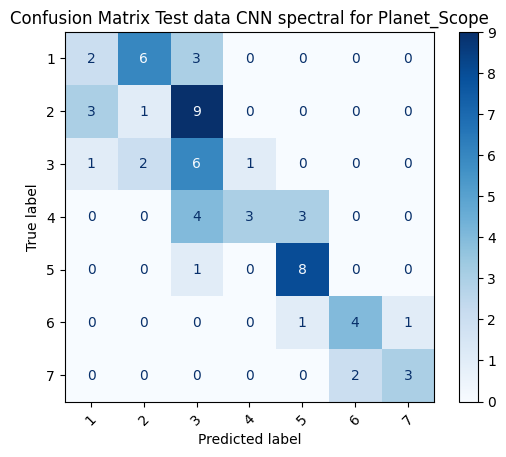

AUC: 0.9745762711864407
Accuracy:  0.421875
R2 0.7657492785246709


In [116]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Train/test split
 
 
# One-hot encode labels
spec='spectral'
le = LabelEncoder()
y1 = le.fit_transform(y)
num_classes = len(np.unique(y1))
y_cat = to_categorical(y1, num_classes)
X_train, X_test, y_train, y_test = train_test_split(
        X_spectral, y_cat, test_size=0.2, random_state=42, stratify=y_cat
    )

 
model_spectral,history_spectral=train_model(X_train,X_test,y_train,y_test)
plot_history(history_spectral)
plot_confusion_matrix(model_spectral, X_train,X_test,y_train,y_test)


<h1>Temporal model</h1>
To train model performing convvolution in temporal dimension we must transpose the data so that concvolution  is performed on each band timeseries

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1811 - loss: 1.9666 - val_accuracy: 0.2031 - val_loss: 1.9429
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2874 - loss: 1.8816 - val_accuracy: 0.2031 - val_loss: 1.9348
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3346 - loss: 1.8059 - val_accuracy: 0.2031 - val_loss: 1.9265
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3386 - loss: 1.7119 - val_accuracy: 0.2031 - val_loss: 1.9188
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3268 - loss: 1.6891 - val_accuracy: 0.2031 - val_loss: 1.9129
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3307 - loss: 1.6438 - val_accuracy: 0.2031 - val_loss: 1.9094
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3819 - loss: 1.5328 - val_accuracy: 0.2031 - val_loss: 1.9085
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3819 - loss: 1.4873 - val_accuracy: 0.203

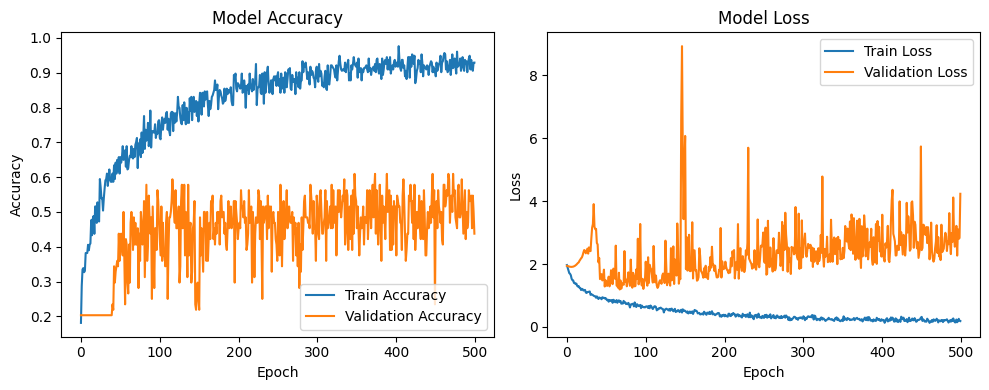

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


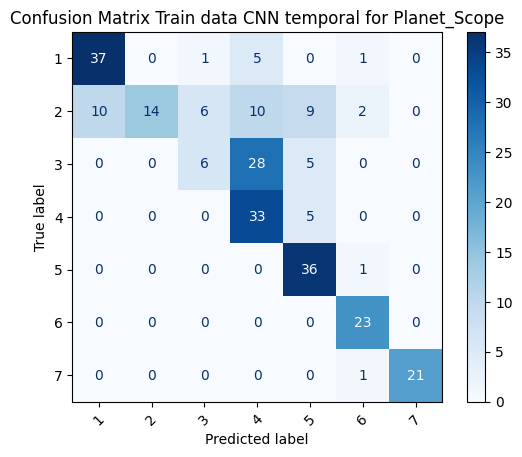

AUC: 0.9973550156739812
Accuracy:  0.6692913385826772
R2 0.6708871767222637
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


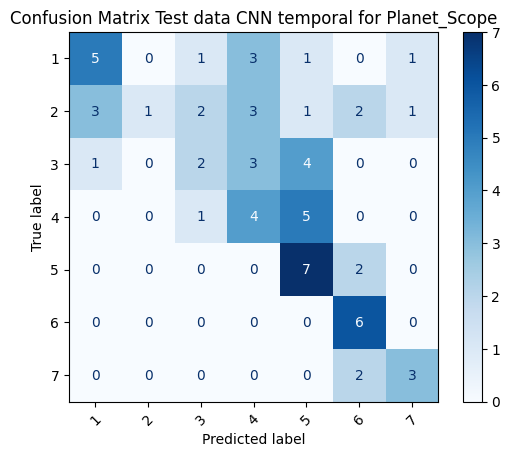

AUC: 0.9423728813559322
Accuracy:  0.4375
R2 0.10354050820018301


In [117]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Train/test split
 
 
# One-hot encode labels
X_temporal = np.transpose(X_spectral, (0, 2, 1))

time_steps = X_spectral.shape[1]
n_features = X_spectral.shape[2]
 
le = LabelEncoder()
y1 = le.fit_transform(y)
num_classes = len(np.unique(y1))
y_cat = to_categorical(y1, num_classes)
X_train, X_test, y_train, y_test = train_test_split(
        X_temporal, y_cat, test_size=0.2, random_state=42, stratify=y_cat
    )
spec="temporal"
 
model_temporal,history_temporal=train_model(X_train,X_test,y_train,y_test)
plot_history(history_temporal)
plot_confusion_matrix(model_temporal, X_train,X_test,y_train,y_test)


<h1>Future prediction</h1>
The trained model can now be used to map water quality index based on timeseries of satellite images from any period. We use satellite images from  one  year period that is different than one the model is trained on. To use the model first we must extract satellite bands and format the dataset 

In [119]:
future_path

'../lakes/vrana/Future/Planet/'

In [ ]:
#Read data
import os
import re
from datetime import datetime
import pandas as pd
import geopandas as gpd
import rasterio
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

base_path = future_path

# --- Step 1: Extract folder dates and map to folder paths ---
folder_date_map = {}
for f in os.listdir(base_path):
    full_path = os.path.join(base_path, f)
    if os.path.isdir(full_path):
        match = re.search(r"(\d{8})", f)
        if match:
            date_obj = datetime.strptime(match.group(1), "%Y%m%d")
            folder_date_map[date_obj] = full_path

folder_dates = sorted(folder_date_map.keys())
#print(folder_date_map)
# --- Step 2: Use gdf from original WQ points for geometry   ---
 
gdf=WQ_points.copy()
# --- Helper to find nearest available folder date ---
def find_nearest_date(target_date, date_list):
    return min(date_list, key=lambda d: abs(d - target_date))

# --- Step 3: Extract pixel values into separate band columns ---

final1=[]
for d in folder_date_map.keys():
    folder_path=folder_date_map[d]
    tiff_files = sorted([f for f in os.listdir(folder_path) if (f.lower().endswith('.tiff') or f.lower().endswith('.tif'))])
     
    for tiff_file in tiff_files:
        # Extract band code from filename (e.g., 'B04')
        if satellite=="Planet_Scope":
            match_band = re.search(r'B(\d{1,2}[A]?)', tiff_file)
        else:
            match_band = re.search(r'_B(\d+[A]?)_', tiff_file)
        if match_band:
            band_code = "B" + match_band.group(1)

            if band_code in band_names:
                #print(d,band_code)
                with rasterio.open(os.path.join(folder_path, tiff_file)) as src:
                    # Ensure CRS matches
                    
                        
                    for idx, row  in gdf.iterrows():
                        
                        point = gdf.to_crs(src.crs).iloc[idx].geometry
                        if gdf.crs != src.crs:
                            point = gdf.to_crs(src.crs).iloc[idx].geometry
                        #print(list(src.sample([(point.x, point.y)])))
                        val = list(src.sample([(point.x, point.y)]))[0][0]
                        final1.append({'ponit':point,'pontid':idx,'date':d,'band':band_code,'val':val,'WQI':row['WQI'],	'Class': row.Class})

                         
                
     
tsdf=pd.DataFrame(final1)


# Make sure date is datetime
tsdf['date'] = pd.to_datetime(tsdf['date'])

# Pivot: one row per (pontid, date), columns are bands
df_wide = tsdf.pivot_table(
    index=['pontid',  'date', 'WQI', 'Class'],
    columns='band',
    values='val'
).reset_index()

# Sort only by pontid (integer) and date
df_wide = df_wide.sort_values(['pontid', 'date'])

# Get list of band names in sorted order
band_names = sorted([c for c in df_wide.columns if c not in ['pontid', 'date','Class', 'WQI']])
band_names  
X_list = []
ids_list = []
dates_list = []
class_list={}
Wqi={}
for pid, group in df_wide.groupby('pontid'):
    group = group.sort_values('date')
    ts_array = group[band_names].to_numpy(dtype=np.float32)  # shape: (num_times, num_bands)
    X_list.append(ts_array)
    ids_list.append(pid)
    dates_list.append(group['date'].to_numpy())
    class_list[pid]=int(group['Class'].max())
  
    Wqi[pid]=group['WQI'].max()
max_len = max(ts.shape[0] for ts in X_list)
num_bands = len(band_names)

# Pad sequences on time axis
X_padded = pad_sequences(
    X_list,
    maxlen=max_len,
    dtype='float32',
    padding='post',
    value=0.0
)  # shape: (num_points, max_len, num_bands)
X_spectral_future = np.transpose(X_padded, (0, 2, 1))
spec1="spectral"
# shape: (num_points, num_bands, max_len)
X_spectral_future.shape 
X_temporal_future = np.transpose(X_spectral_future, (0, 2, 1))
 

{datetime.datetime(2024, 7, 21, 0, 0): '../lakes/vrana/Future/Planet/composite_20240721', datetime.datetime(2024, 8, 15, 0, 0): '../lakes/vrana/Future/Planet/composite_20240815', datetime.datetime(2024, 9, 11, 0, 0): '../lakes/vrana/Future/Planet/composite_20240911', datetime.datetime(2024, 10, 21, 0, 0): '../lakes/vrana/Future/Planet/composite_20241021', datetime.datetime(2024, 11, 11, 0, 0): '../lakes/vrana/Future/Planet/composite_20241111', datetime.datetime(2024, 12, 13, 0, 0): '../lakes/vrana/Future/Planet/composite_20241213', datetime.datetime(2025, 1, 25, 0, 0): '../lakes/vrana/Future/Planet/composite_20250125', datetime.datetime(2025, 2, 19, 0, 0): '../lakes/vrana/Future/Planet/composite_20250219', datetime.datetime(2025, 3, 7, 0, 0): '../lakes/vrana/Future/Planet/composite_20250307', datetime.datetime(2025, 4, 11, 0, 0): '../lakes/vrana/Future/Planet/composite_20250411', datetime.datetime(2025, 5, 4, 0, 0): '../lakes/vrana/Future/Planet/composite_20250504', datetime.datetime(2

<h1>Use model</h1>
Predict the WQI for selected points and store the prediction in shapefile

In [121]:
print(satellite,spec)

Planet_Scope temporal


In [ ]:
spec="spectral"
spec="temporal"

In [125]:
if spec=="spectral":    
    y_future=model_spectral.predict(X_spectral_future
                           )
else:
     y_future=model_temporal.predict(X_temporal_future )

                          
y_indices = np.argmax(y_future, axis=1) 
y_classes=le.inverse_transform(y_indices)
y_classes
WQ_points['predicted']=y_classes
WQ_points.to_file('predicted_'+satellite+'_'+spec+'4.shp',driver="ESRI Shapefile")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
